In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

### **DATASET (PATHS)**

In [2]:
#Dataset Path:
DATASET_DIR = "dataset"

In [3]:
train_x = DATASET_DIR
test_y = DATASET_DIR

**Preprocessing for CNN**

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1563 images belonging to 4 classes.
Found 388 images belonging to 4 classes.


CNN **MODEL**

In [5]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # output layer for the 4 classes we are working with
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_acc)


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.2526 - loss: 1.4010
CNN Test Accuracy: 0.2525773048400879


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = cnn_model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[early_stop])

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 698ms/step - accuracy: 0.3935 - loss: 1.2475 - val_accuracy: 0.4433 - val_loss: 1.2375
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 632ms/step - accuracy: 0.5157 - loss: 1.0787 - val_accuracy: 0.4536 - val_loss: 1.2604
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 643ms/step - accuracy: 0.5867 - loss: 0.9936 - val_accuracy: 0.6289 - val_loss: 0.9107
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 645ms/step - accuracy: 0.6289 - loss: 0.9122 - val_accuracy: 0.6263 - val_loss: 0.9541
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 646ms/step - accuracy: 0.6737 - loss: 0.8385 - val_accuracy: 0.6598 - val_loss: 0.8455
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 633ms/step - accuracy: 0.6743 - loss: 0.8247 - val_accuracy: 0.6804 - val_loss: 0.8202
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 644ms/step - accuracy: 0.6814 - loss: 0.8256 - val_accuracy: 0.7216 - val_loss: 0.7739
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 635ms/step - accuracy: 0.7063 - loss: 0.7650 - val_accu

In [7]:
cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.7474 - loss: 0.6627
CNN Test Accuracy: 0.7474226951599121


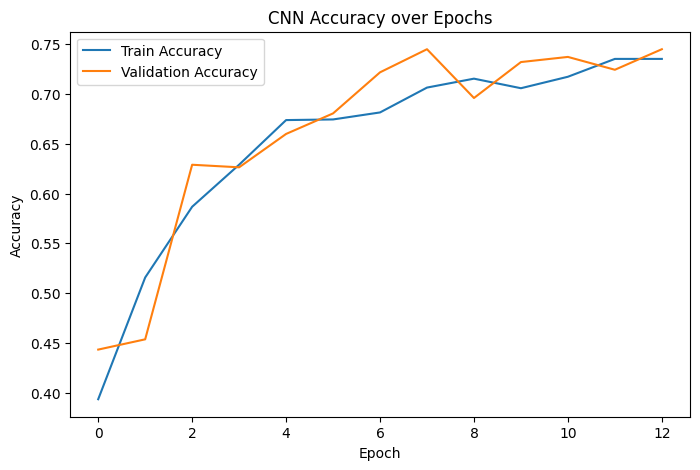

In [8]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

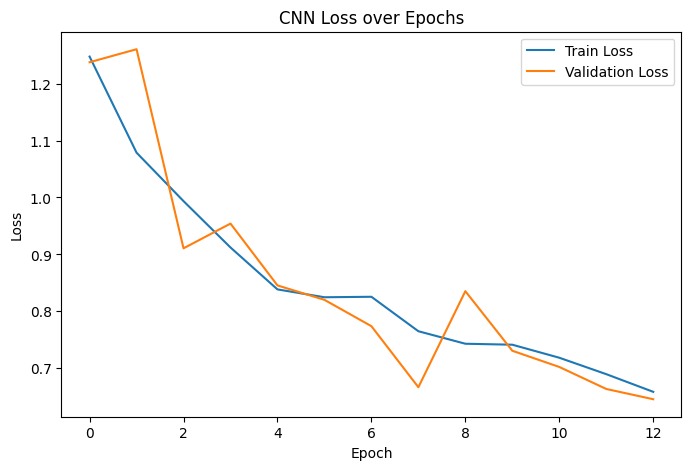

In [9]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Prepare features for **scikit-learn models**

In [10]:
feature_extractor = tf.keras.Sequential()
for layer in cnn_model.layers[:-2]:  # up to Dense(128)
    feature_extractor.add(layer)

def generator_to_arrays(generator):
    X_list, y_list = [], []

    for i in range(len(generator)):
        X_batch, y_batch = generator[i]

        # Extract CNN features instead of raw pixels, which makes both the RF and LR models better.
        features = feature_extractor.predict(X_batch, verbose=0)
        X_list.append(features)

        y_list.append(np.argmax(y_batch, axis=1))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    return X, y


X_train_flat, y_train_flat = generator_to_arrays(train_generator)
X_test_flat, y_test_flat = generator_to_arrays(test_generator)


**Logistic Regression**

In [11]:
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_flat, y_train_flat)
log_acc = accuracy_score(y_test_flat, log_model.predict(X_test_flat))
print("Logistic Regression Test Accuracy:", log_acc)

Logistic Regression Test Accuracy: 0.7783505154639175


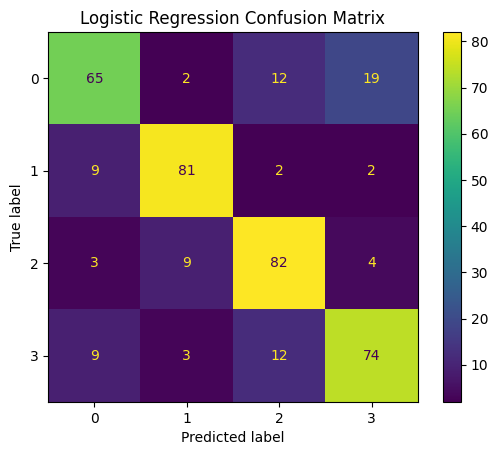

In [12]:
ConfusionMatrixDisplay.from_estimator(log_model, X_test_flat, y_test_flat)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

**Random Forest**

In [13]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_flat, y_train_flat)

rf_preds = rf_model.predict(X_test_flat)
rf_acc = accuracy_score(y_test_flat, rf_preds)
print("Random Forest Test Accuracy:", rf_acc)

Random Forest Test Accuracy: 0.7783505154639175


**Ensemble**

In [14]:
# CNN
cnn_probs = cnn_model.predict(test_generator)

# LR
log_probs = log_model.predict_proba(X_test_flat)

# RF
rf_probs = rf_model.predict_proba(X_test_flat)

# Soft Voting
cnn_conf = np.max(cnn_probs, axis=1)
ensemble_probs = 0.5*rf_probs + 0.25*log_probs + 0.25*cnn_probs
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# True labels
y_true = test_generator.classes

# Evaluate Ensemble
ensemble_acc = np.mean(ensemble_preds == y_true)
print("Ensemble Test Accuracy (Soft Voting):", ensemble_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step
Ensemble Test Accuracy (Soft Voting): 0.788659793814433


**Accuracy list**

In [15]:
accuracy_list = [cnn_model.evaluate(test_generator)[1], log_acc, rf_acc, ensemble_acc]
models = ['CNN', 'Logistic Regression', 'Random Forest', 'Ensemble']

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.7577 - loss: 0.6832


**bar chart**

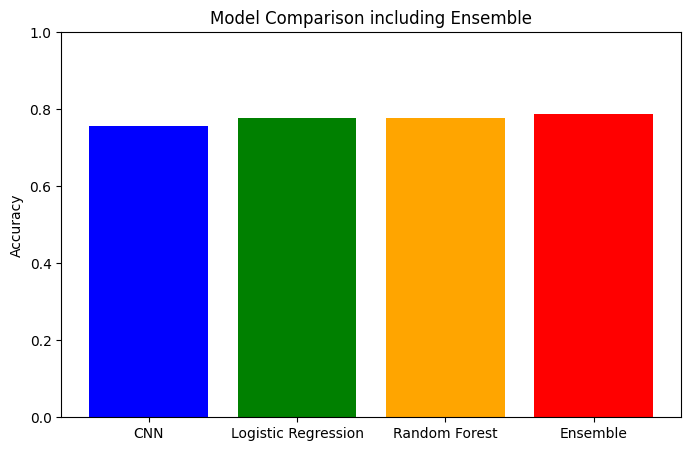

In [16]:
plt.figure(figsize=(8,5))
plt.bar(models, accuracy_list, color=['blue','green','orange','red'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Comparison including Ensemble")
plt.show()

**Comparison Table**

In [17]:
comparison = pd.DataFrame({
    "Model": ["Simple CNN", "Logistic Regression", "Random Forest", "Ensemble"],
    "Test Accuracy": [cnn_acc, log_acc, rf_acc, ensemble_acc],
    "Error Rate": [1-cnn_acc, 1-log_acc, 1-rf_acc, 1-ensemble_acc]
})
print("\nComparison Table:")
print(comparison)


Comparison Table:
                 Model  Test Accuracy  Error Rate
0           Simple CNN       0.747423    0.252577
1  Logistic Regression       0.778351    0.221649
2        Random Forest       0.778351    0.221649
3             Ensemble       0.788660    0.211340


In [18]:
# CNN
cnn_model.save("models/cnn_model.keras")

# Logistic Regression & Random Forest
import joblib
joblib.dump(log_model, "models/log_model.pkl")
joblib.dump(rf_model, "models/rf_model.pkl")

['models/rf_model.pkl']